In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

'[' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


In [2]:
!pip install dtreeviz

In [3]:
#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
import dtreeviz
pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

# Tabular Modeling Deep Dive

Tabular modeling takes data in the form of a table (like a spreadsheet or CSV). The objective is to predict the value in one column based on the values in the other columns. In this chapter we will not only look at deep learning but also more general machine learning techniques like random forests, as they can give better results depending on your problem.

We will look at how we should preprocess and clean the data as well as how to interpret the result of our models after training, but first, we will see how we can feed columns that contain categories into a model that expects numbers by using embeddings.

## Categorical Embeddings

In tabular data some columns may contain numerical data, like "age," while others contain string values, like "sex." The numerical data can be directly fed to the model (with some optional preprocessing), but the other columns need to be converted to numbers. Since the values in those correspond to different categories, we often call this type of variables *categorical variables*. The first type are called *continuous variables*.

> jargon: Continuous and Categorical Variables: Continuous variables are numerical data, such as "age," that can be directly fed to the model, since you can add and multiply them directly. Categorical variables contain a number of discrete levels, such as "movie ID," for which addition and multiplication don't have meaning (even if they're stored as numbers).

At the end of 2015, the [Rossmann sales competition](https://www.kaggle.com/c/rossmann-store-sales) ran on Kaggle. Competitors were given a wide range of information about various stores in Germany, and were tasked with trying to predict sales on a number of days. The goal was to help the company to manage stock properly and be able to satisfy demand without holding unnecessary inventory. The official training set provided a lot of information about the stores. It was also permitted for competitors to use additional data, as long as that data was made public and available to all participants.

One of the gold medalists used deep learning, in one of the earliest known examples of a state-of-the-art deep learning tabular model. Their method involved far less feature engineering, based on domain knowledge, than those of the other gold medalists. The paper, ["Entity Embeddings of Categorical Variables"](https://arxiv.org/abs/1604.06737) describes their approach. In an online-only chapter on the [book's website](https://book.fast.ai/) we show how to replicate it from scratch and attain the same accuracy shown in the paper. In the abstract of the paper the authors (Cheng Guo and Felix Berkhahn) say:

> : Entity embedding not only reduces memory usage and speeds up neural networks compared with one-hot encoding, but more importantly by mapping similar values close to each other in the embedding space it reveals the intrinsic properties of the categorical variables... [It] is especially useful for datasets with lots of high cardinality features, where other methods tend to overfit... As entity embedding defines a distance measure for categorical variables it can be used for visualizing categorical data and for data clustering.

We have already noticed all of these points when we built our collaborative filtering model. We can clearly see that these insights go far beyond just collaborative filtering, however.

The paper also points out that (as we discussed in the last chapter) an embedding layer is exactly equivalent to placing an ordinary linear layer after every one-hot-encoded input layer. The authors used the diagram in <<entity_emb>> to show this equivalence. Note that "dense layer" is a term with the same meaning as "linear layer," and the one-hot encoding layers represent inputs.

<img alt="Entity embeddings in a neural network" width="600" caption="Entity embeddings in a neural network (courtesy of Cheng Guo and Felix Berkhahn)" id="entity_emb" src="images/att_00018.png">

The insight is important because we already know how to train linear layers, so this shows that from the point of view of the architecture and our training algorithm the embedding layer is just another layer. We also saw this in practice in the last chapter, when we built a collaborative filtering neural network that looks exactly like this diagram.

Where we analyzed the embedding weights for movie reviews, the authors of the entity embeddings paper analyzed the embedding weights for their sales prediction model. What they found was quite amazing, and illustrates their second key insight. This is that the embedding transforms the categorical variables into inputs that are both continuous and meaningful.

The images in <<state_emb>> illustrate these ideas. They are based on the approaches used in the paper, along with some analysis we have added.

<img alt="State embeddings and map" width="800" caption="State embeddings and map (courtesy of Cheng Guo and Felix Berkhahn)" id="state_emb" src="images/att_00015.png">

On the left is a plot of the embedding matrix for the possible values of the `State` category. For a categorical variable we call the possible values of the variable its "levels" (or "categories" or "classes"), so here one level is "Berlin," another is "Hamburg," etc. On the right is a map of Germany. The actual physical locations of the German states were not part of the provided data, yet the model itself learned where they must be, based only on the behavior of store sales!

Do you remember how we talked about *distance* between embeddings? The authors of the paper plotted the distance between store embeddings against the actual geographic distance between the stores (see <<store_emb>>). They found that they matched very closely!

<img alt="Store distances" width="600" caption="Store distances (courtesy of Cheng Guo and Felix Berkhahn)" id="store_emb" src="images/att_00016.png">

We've even tried plotting the embeddings for days of the week and months of the year, and found that days and months that are near each other on the calendar ended up close as embeddings too, as shown in <<date_emb>>.

<img alt="Date embeddings" width="900" caption="Date embeddings" id="date_emb" src="images/att_00017.png">

What stands out in these two examples is that we provide the model fundamentally categorical data about discrete entities (e.g., German states or days of the week), and then the model learns an embedding for these entities that defines a continuous notion of distance between them. Because the embedding distance was learned based on real patterns in the data, that distance tends to match up with our intuitions.

In addition, it is valuable in its own right that embeddings are continuous, because models are better at understanding continuous variables. This is unsurprising considering models are built of many continuous parameter weights and continuous activation values, which are updated via gradient descent (a learning algorithm for finding the minimums of continuous functions).

Another benefit is that we can combine our continuous embedding values with truly continuous input data in a straightforward manner: we just concatenate the variables, and feed the concatenation into our first dense layer. In other words, the raw categorical data is transformed by an embedding layer before it interacts with the raw continuous input data. This is how fastai and Guo and Berkhahn handle tabular models containing continuous and categorical variables.

An example using this concatenation approach is how Google does its recommendations on Google Play, as explained in the paper ["Wide & Deep Learning for Recommender Systems"](https://arxiv.org/abs/1606.07792). <<google_recsys>> illustrates.

<img alt="The Google Play recommendation system" width="800" caption="The Google Play recommendation system" id="google_recsys" src="images/att_00019.png">

Interestingly, the Google team actually combined both approaches we saw in the previous chapter: the dot product (which they call *cross product*) and neural network approaches.

Let's pause for a moment. So far, the solution to all of our modeling problems has been: *train a deep learning model*. And indeed, that is a pretty good rule of thumb for complex unstructured data like images, sounds, natural language text, and so forth. Deep learning also works very well for collaborative filtering. But it is not always the best starting point for analyzing tabular data.

## Beyond Deep Learning

Most machine learning courses will throw dozens of different algorithms at you, with a brief technical description of the math behind them and maybe a toy example. You're left confused by the enormous range of techniques shown and have little practical understanding of how to apply them.

The good news is that modern machine learning can be distilled down to a couple of key techniques that are widely applicable. Recent studies have shown that the vast majority of datasets can be best modeled with just two methods:

1. Ensembles of decision trees (i.e., random forests and gradient boosting machines), mainly for structured data (such as you might find in a database table at most companies)
1. Multilayered neural networks learned with SGD (i.e., shallow and/or deep learning), mainly for unstructured data (such as audio, images, and natural language)

Although deep learning is nearly always clearly superior for unstructured data, these two approaches tend to give quite similar results for many kinds of structured data. But ensembles of decision trees tend to train faster, are often easier to interpret, do not require special GPU hardware for inference at scale, and often require less hyperparameter tuning. They have also been popular for quite a lot longer than deep learning, so there is a more mature ecosystem of tooling and documentation around them.

Most importantly, the critical step of interpreting a model of tabular data is significantly easier for decision tree ensembles. There are tools and methods for answering the pertinent questions, like: Which columns in the dataset were the most important for your predictions? How are they related to the dependent variable? How do they interact with each other? And which particular features were most important for some particular observation?

Therefore, ensembles of decision trees are our first approach for analyzing a new tabular dataset.

The exception to this guideline is when the dataset meets one of these conditions:

- There are some high-cardinality categorical variables that are very important ("cardinality" refers to the number of discrete levels representing categories, so a high-cardinality categorical variable is something like a zip code, which can take on thousands of possible levels).
- There are some columns that contain data that would be best understood with a neural network, such as plain text data.

In practice, when we deal with datasets that meet these exceptional conditions, we always try both decision tree ensembles and deep learning to see which works best. It is likely that deep learning will be a useful approach in our example of collaborative filtering, as we have at least two high-cardinality categorical variables: the users and the movies. But in practice things tend to be less cut-and-dried, and there will often be a mixture of high- and low-cardinality categorical variables and continuous variables.

Either way, it's clear that we are going to need to add decision tree ensembles to our modeling toolbox!

Up to now we've used PyTorch and fastai for pretty much all of our heavy lifting. But these libraries are mainly designed for algorithms that do lots of matrix multiplication and derivatives (that is, stuff like deep learning!). Decision trees don't depend on these operations at all, so PyTorch isn't much use.

Instead, we will be largely relying on a library called scikit-learn (also known as `sklearn`). Scikit-learn is a popular library for creating machine learning models, using approaches that are not covered by deep learning. In addition, we'll need to do some tabular data processing and querying, so we'll want to use the Pandas library. Finally, we'll also need NumPy, since that's the main numeric programming library that both sklearn and Pandas rely on.

We don't have time to do a deep dive into all these libraries in this book, so we'll just be touching on some of the main parts of each. For a far more in depth discussion, we strongly suggest Wes McKinney's [Python for Data Analysis](http://shop.oreilly.com/product/0636920023784.do) (O'Reilly). Wes is the creator of Pandas, so you can be sure that the information is accurate!

First, let's gather the data we will use.

## The Dataset

The dataset we use in this chapter is from the Blue Book for Bulldozers Kaggle competition, which has the following description: "The goal of the contest is to predict the sale price of a particular piece of heavy equipment at auction based on its usage, equipment type, and configuration.  The data is sourced from auction result postings and includes information on usage and equipment configurations."

This is a very common type of dataset and prediction problem, similar to what you may see in your project or workplace. The dataset is available for download on Kaggle, a website that hosts data science competitions.

### Kaggle Competitions

Kaggle is an awesome resource for aspiring data scientists or anyone looking to improve their machine learning skills.  There is nothing like getting hands-on practice and receiving real-time feedback to help you improve your skills.

Kaggle provides:

- Interesting datasets
- Feedback on how you're doing
- A leaderboard to see what's good, what's possible, and what's state-of-the-art
- Blog posts by winning contestants sharing useful tips and techniques

Until now all our datasets have been available to download through fastai's integrated dataset system. However, the dataset we will be using in this chapter is only available from Kaggle. Therefore, you will need to register on the site, then go to the [page for the competition](https://www.kaggle.com/c/bluebook-for-bulldozers). On that page click "Rules," then "I Understand and Accept." (Although the competition has finished, and you will not be entering it, you still have to agree to the rules to be allowed to download the data.)

The easiest way to download Kaggle datasets is to use the Kaggle API. You can install this using `pip` by running this in a notebook cell:

    !pip install kaggle

You need an API key to use the Kaggle API; to get one, click on your profile picture on the Kaggle website, and choose My Account, then click Create New API Token. This will save a file called *kaggle.json* to your PC. You need to copy this key on your GPU server. To do so, open the file you downloaded, copy the contents, and paste them in the following cell in the notebook associated with this chapter (e.g., `creds = '{"username":"xxx","key":"xxx"}'`):

In [4]:
creds = '{"username":"shaunchen284","key":"b83043675fd88fbe9dac3e31a6a5bf6d"}'


Then execute this cell (this only needs to be run once):

In [5]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [6]:
cred_path

Path('C:/Users/lenovo/.kaggle/kaggle.json')

Now you can download datasets from Kaggle! Pick a path to download the dataset to:

In [7]:
comp = 'bluebook-for-bulldozers'
path = URLs.path(comp) 
'''URLs对象的path方法， 生成路径'''
path

Path('C:/Users/lenovo/.fastai/archive/bluebook-for-bulldozers')

In [8]:
Path

pathlib.Path

In [9]:
#hide
Path.BASE_PATH = path

And use the Kaggle API to download the dataset to that path, and extract it:

In [10]:
!pip install kaggle

In [11]:
comp

'bluebook-for-bulldozers'

In [12]:
from kaggle import api

if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

path.ls(file_type='text')

(#0) []

Now that we have downloaded our dataset, let's take a look at it!

### Look at the Data

Kaggle provides information about some of the fields of our dataset. The [Data](https://www.kaggle.com/c/bluebook-for-bulldozers/data) explains that the key fields in *train.csv* are:

- `SalesID`:: The unique identifier of the sale.
- `MachineID`:: The unique identifier of a machine.  A machine can be sold multiple times.
- `saleprice`:: What the machine sold for at auction (only provided in *train.csv*).
- `saledate`:: The date of the sale.

In any sort of data science work, it's important to *look at your data directly* to make sure you understand the format, how it's stored, what types of values it holds, etc. Even if you've read a description of the data, the actual data may not be what you expect. We'll start by reading the training set into a Pandas DataFrame. Generally it's a good idea to specify `low_memory=False` unless Pandas actually runs out of memory and returns an error. The `low_memory` parameter, which is `True` by default, tells Pandas to only look at a few rows of data at a time to figure out what type of data is in each column. This means that Pandas can actually end up using different data type for different rows, which generally leads to data processing errors or model training problems later.

Let's load our data and have a look at the columns:

In [13]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [14]:
df = pd.read_csv(path/'TrainAndValid.csv',low_memory= False)


In [15]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [16]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

That's a lot of columns for us to look at! Try looking through the dataset to get a sense of what kind of information is in each one. We'll shortly see how to "zero in" on the most interesting bits.

At this point, a good next step is to handle *ordinal columns*. This refers to columns containing strings or similar, but where those strings have a natural ordering. For instance, here are the levels of `ProductSize`:

In [17]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [18]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

We can tell Pandas about a suitable ordering of these levels like so:

In [19]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

In [20]:
sizes = 'Large','Large / Medium','Medium','Small','Mini', 'Compact'

In [21]:
# df['ProductSize'] = df['ProductSize'].astype('category')
# df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

In [22]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'] = df['ProductSize'].cat.set_categories(sizes,ordered=True)

In [23]:
print(pd.__version__)

2.1.0


The most important data column is the dependent variable—that is, the one we want to predict. Recall that a model's metric is a function that reflects how good the predictions are. It's important to note what metric is being used for a project. Generally, selecting the metric is an important part of the project setup. In many cases, choosing a good metric will require more than just selecting a variable that already exists. It is more like a design process. You should think carefully about which metric, or set of metrics, actually measures the notion of model quality that matters to you. If no variable represents that metric, you should see if you can build the metric from the variables that are available.

However, in this case Kaggle tells us what metric to use: root mean squared log error (RMSLE) between the actual and predicted auction prices. We need do only a small amount of processing to use this: we take the log of the prices, so that `rmse` of that value will give us what we ultimately need:

In [24]:
dep_var = 'SalePrice'

In [25]:
dep_var = 'SalePrice'

In [26]:
df[dep_var]=np.log(df[dep_var])

In [27]:
df[dep_var] = np.log(df[dep_var])

In [28]:
df[dep_var]

0         2.406712
1         2.393413
2         2.220327
3         2.356923
4         2.230622
            ...   
412693    2.220327
412694    2.225610
412695    2.244265
412696    2.220327
412697    2.248414
Name: SalePrice, Length: 412698, dtype: float64

We are now ready to explore our first machine learning algorithm for tabular data: decision trees.

## Decision Trees

Decision tree ensembles, as the name suggests, rely on decision trees. So let's start there! A decision tree asks a series of binary (that is, yes or no) questions about the data. After each question the data at that part of the tree is split between a "yes" and a "no" branch, as shown in <<decision_tree>>. After one or more questions, either a prediction can be made on the basis of all previous answers or another question is required.

<img alt="An example of decision tree" width="600" caption="An example of decision tree" id="decision_tree" src="images/decision_tree.PNG">

This sequence of questions is now a procedure for taking any data item, whether an item from the training set or a new one, and assigning that item to a group. Namely, after asking and answering the questions, we can say the item belongs to the same group as all the other training data items that yielded the same set of answers to the questions. But what good is this? The goal of our model is to predict values for items, not to assign them into groups from the training dataset. The value is that we can now assign a prediction value for each of these groups—for regression, we take the target mean of the items in the group.

Let's consider how we find the right questions to ask. Of course, we wouldn't want to have to create all these questions ourselves—that's what computers are for! The basic steps to train a decision tree can be written down very easily:

1. Loop through each column of the dataset in turn.
1. For each column, loop through each possible level of that column in turn.
1. Try splitting the data into two groups, based on whether they are greater than or less than that value (or if it is a categorical variable, based on whether they are equal to or not equal to that level of that categorical variable).
1. Find the average sale price for each of those two groups, and see how close that is to the actual sale price of each of the items of equipment in that group. That is, treat this as a very simple "model" where our predictions are simply the average sale price of the item's group.
1. After looping through all of the columns and all the possible levels for each, pick the split point that gave the best predictions using that simple model.
1. We now have two different groups for our data, based on this selected split. Treat each of these as separate datasets, and find the best split for each by going back to step 1 for each group.
1. Continue this process recursively, until you have reached some stopping criterion for each group—for instance, stop splitting a group further when it has only 20 items in it.

Although this is an easy enough algorithm to implement yourself (and it is a good exercise to do so), we can save some time by using the implementation built into sklearn.

First, however, we need to do a little data preparation.

> A: Here's a productive question to ponder. If you consider that the procedure for defining a decision tree essentially chooses one _sequence of splitting questions about variables_, you might ask yourself, how do we know this procedure chooses the _correct sequence_? The rule is to choose the splitting question that produces the best split (i.e., that most accurately separates the items into two distinct categories), and then to apply the same rule to the groups that split produces, and so on. This is known in computer science as a "greedy" approach. Can you imagine a scenario in which asking a “less powerful” splitting question would enable a better split down the road (or should I say down the trunk!) and lead to a better result overall?

### Handling Dates

The first piece of data preparation we need to do is to enrich our representation of dates. The fundamental basis of the decision tree that we just described is *bisection*— dividing a group into two. We look at the ordinal variables and divide up the dataset based on whether the variable's value is greater (or lower) than a threshold, and we look at the categorical variables and divide up the dataset based on whether the variable's level is a particular level. So this algorithm has a way of dividing up the dataset based on both ordinal and categorical data.

But how does this apply to a common data type, the date? You might want to treat a date as an ordinal value, because it is meaningful to say that one date is greater than another. However, dates are a bit different from most ordinal values in that some dates are qualitatively different from others in a way that that is often relevant to the systems we are modeling.

In order to help our algorithm handle dates intelligently, we'd like our model to know more than whether a date is more recent or less recent than another. We might want our model to make decisions based on that date's day of the week, on whether a day is a holiday, on what month it is in, and so forth. To do this, we replace every date column with a set of date metadata columns, such as holiday, day of week, and month. These columns provide categorical data that we suspect will be useful.

fastai comes with a function that will do this for us—we just have to pass a column name that contains dates:

In [29]:
df = add_datepart(df, 'saledate')

c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\fastai\tabular\core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [30]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',


Let's do the same for the test set while we're there:

In [31]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\fastai\tabular\core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [32]:
df_test = pd.read_csv(path/'Test.csv',low_memory=False)
df_test = add_datepart(df_test,'saledate')

c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\fastai\tabular\core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


We can see that there are now lots of new columns in our DataFrame:

In [33]:
'  '.join(o for o in df.columns if o.startswith('sale'))
'''连接列表解析中选择的列名，用空格 ' ' 分隔每个列名'''

"连接列表解析中选择的列名，用空格 ' ' 分隔每个列名"

In [34]:
' '.join(o for o in df if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

This is a good first step, but we will need to do a bit more cleaning. For this, we will use fastai objects called `TabularPandas` and `TabularProc`.

### Using TabularPandas and TabularProc

A second piece of preparatory processing is to be sure we can handle strings and missing data. Out of the box, sklearn cannot do either. Instead we will use fastai's class `TabularPandas`, which wraps a Pandas DataFrame and provides a few conveniences. To populate a `TabularPandas`, we will use two  `TabularProc`s, `Categorify` and `FillMissing`. A `TabularProc` is like a regular `Transform`, except that:

- It returns the exact same object that's passed to it, after modifying the object in place.
- It runs the transform once, when data is first passed in, rather than lazily as the data is accessed.

`Categorify` is a `TabularProc` that replaces a column with a numeric categorical column. `FillMissing` is a `TabularProc` that replaces missing values with the median of the column, and creates a new Boolean column that is set to `True` for any row where the value was missing. These two transforms are needed for nearly every tabular dataset you will use, so this is a good starting point for your data processing:

In [35]:
procs = [Categorify, FillMissing]

In [36]:
procs = [Categorify,FillMissing]

`TabularPandas` will also handle splitting the dataset into training and validation sets for us. However we need to be very careful about our validation set. We want to design it so that it is like the *test set* Kaggle will use to judge the contest.

Recall the distinction between a validation set and a test set, as discussed in <<chapter_intro>>. A validation set is data we hold back from training in order to ensure that the training process does not overfit on the training data. A test set is data that is held back even more deeply, from us ourselves, in order to ensure that *we* don't overfit on the validation data, as we explore various model architectures and hyperparameters.

We don't get to see the test set. But we do want to define our validation data so that it has the same sort of relationship to the training data as the test set will have.

In some cases, just randomly choosing a subset of your data points will do that. This is not one of those cases, because it is a time series.

If you look at the date range represented in the test set, you will discover that it covers a six-month period from May 2012, which is later in time than any date in the training set. This is a good design, because the competition sponsor will want to ensure that a model is able to predict the future. But it means that if we are going to have a useful validation set, we also want the validation set to be later in time than the training set. The Kaggle training data ends in April 2012, so we will define a narrower training dataset which consists only of the Kaggle training data from before November 2011, and we'll define a validation set consisting of data from after November 2011.

To do this we use `np.where`, a useful function that returns (as the first element of a tuple) the indices of all `True` values:

In [37]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [38]:
type(splits)
df_new = df.iloc[train_idx,:]

In [39]:
df_new.saleYear>=2011

0         False
1         False
2         False
3          True
4         False
          ...  
412693     True
412694     True
412695     True
412696     True
412697     True
Name: saleYear, Length: 404710, dtype: bool

`TabularPandas` needs to be told which columns are continuous and which are categorical. We can handle that automatically using the helper function `cont_cat_split`:

In [40]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
''' max_card 表示最大的分类类别数量，即当一列中的不同类别数量不超过 max_card 时，
将该列视为分类列，否则视为连续数值型列。'''

' max_card 表示最大的分类类别数量，即当一列中的不同类别数量不超过 max_card 时，\n将该列视为分类列，否则视为连续数值型列。'

In [41]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\fastai\data\transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\fastai\tabular\core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\fastai\tabular\core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\fastai\tabular\core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\fastai\tabular\core.py:233: FutureWarning: i

In [42]:
to = TabularPandas(df,procs=procs,cat_names=cat,cont_names=cont,y_names=dep_var,splits=splits)

c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\fastai\data\transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\fastai\tabular\core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\fastai\tabular\core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\fastai\tabular\core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\fastai\tabular\core.py:233: FutureWarning: i

A `TabularPandas` behaves a lot like a fastai `Datasets` object, including providing `train` and `valid` attributes:

In [43]:
len(to.train),len(to.valid)

(404710, 7988)

We can see that the data is still displayed as strings for categories (we only show a few columns here because the full table is too big to fit on a page):

In [44]:
#hide_output
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,2.406712
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,2.393413
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,2.220327


In [45]:
#hide_input
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], [], y_names=dep_var, splits=splits)
to1.show(3)

c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\fastai\data\transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\fastai\tabular\core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\fastai\tabular\core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\fastai\tabular\core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\fastai\tabular\core.py:233: FutureWarning: i

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,2.406712
1,North Carolina,WL,#na#,EROPS w AC,2.393413
2,New York,SSL,#na#,OROPS,2.220327


However, the underlying items are all numeric:

In [46]:
#hide_output
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,2.406712,999089,3157,...,1,1.163635e+09,1,1
1,1139248,2.393413,117657,77,...,1,1.080259e+09,1,1
2,1139249,2.220327,434808,7009,...,1,1.077754e+09,1,1


In [47]:
#hide_input
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


In [48]:
to1.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,2.406712,999089,3157,...,False,False,False,1.163635e+09
1,1139248,2.393413,117657,77,...,False,False,False,1.080259e+09
2,1139249,2.220327,434808,7009,...,False,False,False,1.077754e+09


The conversion of categorical columns to numbers is done by simply replacing each unique level with a number. The numbers associated with the levels are chosen consecutively as they are seen in a column, so there's no particular meaning to the numbers in categorical columns after conversion. The exception is if you first convert a column to a Pandas ordered category (as we did for `ProductSize` earlier), in which case the ordering you chose is used. We can see the mapping by looking at the `classes` attribute:

In [49]:
to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

In [50]:
to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

Since it takes a minute or so to process the data to get to this point, we should save it—that way in the future we can continue our work from here without rerunning the previous steps. fastai provides a `save` method that uses Python's *pickle* system to save nearly any Python object:

In [51]:
save_pickle(path/'to.pkl',to)

In [52]:

to.items.head(3)
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,2.406712
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,2.393413
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,2.220327


In [53]:
type(df),type(to)

(pandas.core.frame.DataFrame, fastai.tabular.core.TabularPandas)

To read this back later, you would type:

```python
to = (path/'to.pkl').load()
```

Now that all this preprocessing is done, we are ready to create a decision tree.

### Creating the Decision Tree

To begin, we define our independent and dependent variables:

In [54]:
#hide
to = load_pickle(path/'to.pkl')

In [55]:
to = load_pickle(path/'to.pkl')

In [56]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [57]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

Now that our data is all numeric, and there are no missing values, we can create a decision tree:

In [58]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs,y);

To keep it simple, we've told sklearn to just create four *leaf nodes*. To see what it's learned, we can display the tree:

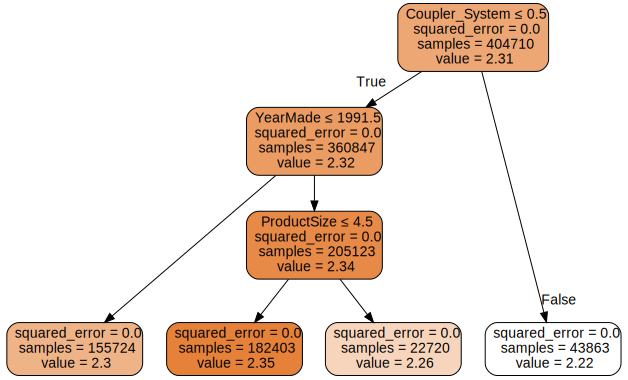

In [59]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

Understanding this picture is one of the best ways to understand decision trees, so we will start at the top and explain each part step by step.

The top node represents the *initial model* before any splits have been done, when all the data is in one group. This is the simplest possible model. It is the result of asking zero questions and will always predict the value to be the average value of the whole dataset. In this case, we can see it predicts a value of 10.10 for the logarithm of the sales price. It gives a mean squared error of 0.48. The square root of this is 0.69. (Remember that unless you see `m_rmse`, or a *root mean squared error*, then the value you are looking at is before taking the square root, so it is just the average of the square of the differences.) We can also see that there are 404,710 auction records in this group—that is the total size of our training set. The final piece of information shown here is the decision criterion for the best split that was found, which is to split based on the `coupler_system` column.

Moving down and to the left, this node shows us that there were 360,847 auction records for equipment where `coupler_system` was less than 0.5. The average value of our dependent variable in this group is 10.21. Moving down and to the right from the initial model takes us to the records where `coupler_system` was greater than 0.5.

The bottom row contains our *leaf nodes*: the nodes with no answers coming out of them, because there are no more questions to be answered. At the far right of this row is the node containing records where `coupler_system` was greater than 0.5. The average value here is 9.21, so we can see the decision tree algorithm did find a single binary decision that separated high-value from low-value auction results. Asking only about `coupler_system` predicts an average value of 9.21 versus 10.1.

Returning back to the top node after the first decision point, we can see that a second binary decision split has been made, based on asking whether `YearMade` is less than or equal to 1991.5. For the group where this is true (remember, this is now following two binary decisions, based on `coupler_system` and `YearMade`) the average value is 9.97, and there are 155,724 auction records in this group. For the group of auctions where this decision is false, the average value is 10.4, and there are 205,123 records. So again, we can see that the decision tree algorithm has successfully split our more expensive auction records into two more groups which differ in value significantly.

We can show the same information using Terence Parr's powerful [dtreeviz](https://explained.ai/decision-tree-viz/) library:

In [60]:
# samp_idx = np.random.permutation(len(y))[:500]
# dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
#         fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
#         orientation='LR')

TypeError: 'module' object is not callable

This shows a chart of the distribution of the data for each split point. We can clearly see that there's a problem with our `YearMade` data: there are bulldozers made in the year 1000, apparently! Presumably this is actually just a missing value code (a value that doesn't otherwise appear in the data and that is used as a placeholder in cases where a value is missing). For modeling purposes, 1000 is fine, but as you can see this outlier makes visualization of the values we are interested in more difficult. So, let's replace it with 1950:

In [64]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

In [62]:
xs['saleDay']

0         16
1         26
2         26
3         19
4         23
          ..
412693     7
412694    28
412695    28
412696     7
412697    28
Name: saleDay, Length: 404710, dtype: int8

That change makes the split much clearer in the tree visualization, even although it doesn't actually change the result of the model in any significant way. This is a great example of how resilient decision trees are to data issues!

In [63]:
# m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

# dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
#         fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
#         orientation='LR')

TypeError: 'module' object is not callable

Let's now have the decision tree algorithm build a bigger tree. Here, we are not passing in any stopping criteria such as `max_leaf_nodes`:

In [65]:
m = DecisionTreeRegressor()
m.fit(xs, y);

We'll create a little function to check the root mean squared error of our model (`m_rmse`), since that's how the competition was judged:

In [66]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
'''round(..., 6)将在括号内的结果保留 6 位小数'''
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [67]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()),6)
def m_rmse(m,xs,y):return r_mse(m.predict(xs),y)

In [68]:
m_rmse(m, xs, y)

0.0

So, our model is perfect, right? Not so fast... remember we really need to check the validation set, to ensure we're not overfitting:

In [69]:
m_rmse(m, valid_xs, valid_y)

0.033227

In [70]:
m_rmse(m,valid_xs,valid_y)

0.033227

Oops—it looks like we might be overfitting pretty badly. Here's why:

In [71]:
m.get_n_leaves(), len(xs)

(325138, 404710)

In [72]:
m.get_n_leaves(),len(xs)

(325138, 404710)

We've got nearly as many leaf nodes as data points! That seems a little over-enthusiastic. Indeed, sklearn's default settings allow it to continue splitting nodes until there is only one item in each leaf node. Let's change the stopping rule to tell sklearn to ensure every leaf node contains at least 25 auction records:

In [73]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.025245, 0.032205)

In [74]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(xs,y)
m_rmse(m,xs,y),m_rmse(m,valid_xs,valid_y)

(0.021061, 0.026542)

That looks much better. Let's check the number of leaves again:

In [75]:
m.get_n_leaves()

12354

In [76]:
m.get_n_leaves()

12354

Much more reasonable!

> A: Here's my intuition for an overfitting decision tree with more leaf nodes than data items. Consider the game Twenty Questions. In that game, the chooser secretly imagines an object (like, "our television set"), and the guesser gets to pose 20 yes or no questions to try to guess what the object is (like "Is it bigger than a breadbox?"). The guesser is not trying to predict a numerical value, but just to identify a particular object out of the set of all imaginable objects. When your decision tree has more leaves than there are possible objects in your domain, then it is essentially a well-trained guesser. It has learned the sequence of questions needed to identify a particular data item in the training set, and it is "predicting" only by describing that item's value. This is a way of memorizing the training set—i.e., of overfitting.

Building a decision tree is a good way to create a model of our data. It is very flexible, since it can clearly handle nonlinear relationships and interactions between variables. But we can see there is a fundamental compromise between how well it generalizes (which we can achieve by creating small trees) and how accurate it is on the training set (which we can achieve by using large trees).

So how do we get the best of both worlds? We'll show you right after we handle an important missing detail: how to handle categorical variables.

### Categorical Variables

In the previous chapter, when working with deep learning networks, we dealt with categorical variables by one-hot encoding them and feeding them to an embedding layer. The embedding layer helped the model to discover the meaning of the different levels of these variables (the levels of a categorical variable do not have an intrinsic meaning, unless we manually specify an ordering using Pandas). In a decision tree, we don't have embeddings layers—so how can these untreated categorical variables do anything useful in a decision tree? For instance, how could something like a product code be used?

The short answer is: it just works! Think about a situation where there is one product code that is far more expensive at auction than any other one. In that case, any binary split will result in that one product code being in some group, and that group will be more expensive than the other group. Therefore, our simple decision tree building algorithm will choose that split. Later during training the algorithm will be able to further split the subgroup that contains the expensive product code, and over time, the tree will home in on that one expensive product.

It is also possible to use one-hot encoding to replace a single categorical variable with multiple one-hot-encoded columns, where each column represents a possible level of the variable. Pandas has a `get_dummies` method which does just that.

However, there is not really any evidence that such an approach improves the end result. So, we generally avoid it where possible, because it does end up making your dataset harder to work with. In 2019 this issue was explored in the paper ["Splitting on Categorical Predictors in Random Forests"](https://peerj.com/articles/6339/) by Marvin Wright and Inke König, which said:

> : The standard approach for nominal predictors is to consider all $2^{k-1} − 1$ 2-partitions of the *k* predictor categories. However, this exponential relationship produces a large number of potential splits to be evaluated, increasing computational complexity and restricting the possible number of categories in most implementations. For binary classification and regression, it was shown that ordering the predictor categories in each split leads to exactly the same splits as the standard approach. This reduces computational complexity because only *k* − 1 splits have to be considered for a nominal predictor with *k* categories.

Now that you understand how decisions tree work, it's time for the best-of-both-worlds solution: random forests.

## Random Forests

In 1994 Berkeley professor Leo Breiman, one year after his retirement, published a small technical report called ["Bagging Predictors"](https://www.stat.berkeley.edu/~breiman/bagging.pdf), which turned out to be one of the most influential ideas in modern machine learning. The report began:

> : Bagging predictors is a method for generating multiple versions of a predictor and using these to get an aggregated predictor. The aggregation averages over the versions... The multiple versions are formed by making bootstrap replicates of the learning set and using these as new learning sets. Tests… show that bagging can give substantial gains in accuracy. The vital element is the instability of the prediction method. If perturbing the learning set can cause significant changes in the predictor constructed, then bagging can improve accuracy.

Here is the procedure that Breiman is proposing:

1. Randomly choose a subset of the rows of your data (i.e., "bootstrap replicates of your learning set").
1. Train a model using this subset.
1. Save that model, and then return to step 1 a few times.
1. This will give you a number of trained models. To make a prediction, predict using all of the models, and then take the average of each of those model's predictions.

This procedure is known as "bagging." It is based on a deep and important insight: although each of the models trained on a subset of data will make more errors than a model trained on the full dataset, those errors will not be correlated with each other. Different models will make different errors. The average of those errors, therefore, is: zero! So if we take the average of all of the models' predictions, then we should end up with a prediction that gets closer and closer to the correct answer, the more models we have. This is an extraordinary result—it means that we can improve the accuracy of nearly any kind of machine learning algorithm by training it multiple times, each time on a different random subset of the data, and averaging its predictions.

In 2001 Leo Breiman went on to demonstrate that this approach to building models, when applied to decision tree building algorithms, was particularly powerful. He went even further than just randomly choosing rows for each model's training, but also randomly selected from a subset of columns when choosing each split in each decision tree. He called this method the *random forest*. Today it is, perhaps, the most widely used and practically important machine learning method.

In essence a random forest is a model that averages the predictions of a large number of decision trees, which are generated by randomly varying various parameters that specify what data is used to train the tree and other tree parameters. Bagging is a particular approach to "ensembling," or combining the results of multiple models together. To see how it works in practice, let's get started on creating our own random forest!

In [77]:
#hide
# pip install —pre -f https://sklearn-nightly.scdn8.secure.raxcdn.com scikit-learn —U

### Creating a Random Forest

We can create a random forest just like we created a decision tree, except now, we are also specifying parameters that indicate how many trees should be in the forest, how we should subset the data items (the rows), and how we should subset the fields (the columns).

In the following function definition `n_estimators` defines the number of trees we want, `max_samples` defines how many rows to sample for training each tree, and `max_features` defines how many columns to sample at each split point (where `0.5` means "take half the total number of columns"). We can also specify when to stop splitting the tree nodes, effectively limiting the depth of the tree, by including the same `min_samples_leaf` parameter we used in the last section. Finally, we pass `n_jobs=-1` to tell sklearn to use all our CPUs to build the trees in parallel. By creating a little function for this, we can more quickly try different variations in the rest of this chapter:

In [78]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [79]:
m = rf(xs, y);

Our validation RMSE is now much improved over our last result produced by the `DecisionTreeRegressor`, which made just one tree using all the available data:

In [80]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.01712, 0.023149)

One of the most important properties of random forests is that they aren't very sensitive to the hyperparameter choices, such as `max_features`. You can set `n_estimators` to as high a number as you have time to train—the more trees you have, the more accurate the model will be. `max_samples` can often be left at its default, unless you have over 200,000 data points, in which case setting it to 200,000 will make it train faster with little impact on accuracy. `max_features=0.5` and `min_samples_leaf=4` both tend to work well, although sklearn's defaults work well too.

The sklearn docs [show an example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) of the effects of different `max_features` choices, with increasing numbers of trees. In the plot, the blue plot line uses the fewest features and the green line uses the most (it uses all the features). As you can see in <<max_features>>, the models with the lowest error result from using a subset of features but with a larger number of trees.

<img alt="sklearn max_features chart" width="500" caption="Error based on max features and number of trees (source: https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html)" src="images/sklearn_features.png" id="max_features"/>

To see the impact of `n_estimators`, let's get the predictions from each individual tree in our forest (these are in the `estimators_` attribute):

In [81]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fit

As you can see, `preds.mean(0)` gives the same results as our random forest:

In [82]:
r_mse(preds.mean(0), valid_y)

0.023149

Let's see what happens to the RMSE as we add more and more trees. As you can see, the improvement levels off quite a bit after around 30 trees:

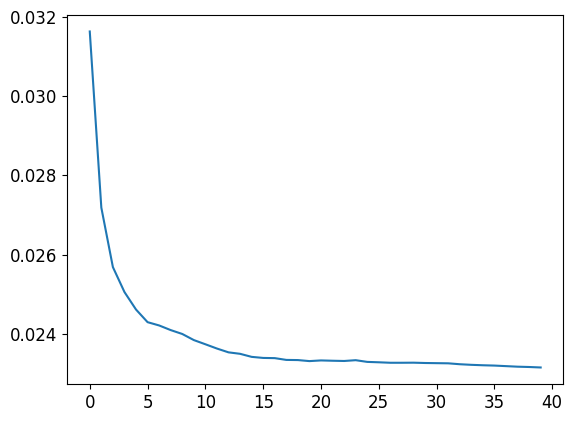

In [83]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

The performance on our validation set is worse than on our training set. But is that because we're overfitting, or because the validation set covers a different time period, or a bit of both? With the existing information we've seen, we can't tell. However, random forests have a very clever trick called *out-of-bag* (OOB) error that can help us with this (and more!).

### Out-of-Bag Error

Recall that in a random forest, each tree is trained on a different subset of the training data. The OOB error is a way of measuring prediction error on the training set by only including in the calculation of a row's error trees where that row was *not* included in training. This allows us to see whether the model is overfitting, without needing a separate validation set.

> A: My intuition for this is that, since every tree was trained with a different randomly selected subset of rows, out-of-bag error is a little like imagining that every tree therefore also has its own validation set. That validation set is simply the rows that were not selected for that tree's training.

This is particularly beneficial in cases where we have only a small amount of training data, as it allows us to see whether our model generalizes without removing items to create a validation set. The OOB predictions are available in the `oob_prediction_` attribute. Note that we compare them to the training labels, since this is being calculated on trees using the training set.

In [84]:
r_mse(m.oob_prediction_, y)

0.021113

We can see that our OOB error is much lower than our validation set error. This means that something else is causing that error, in *addition* to normal generalization error. We'll discuss the reasons for this later in this chapter.

This is one way to interpret our model's predictions—let's focus on more of those now.

## Model Interpretation

For tabular data, model interpretation is particularly important. For a given model, the things we are most likely to be interested in are:

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?

As we will see, random forests are particularly well suited to answering these questions. Let's start with the first one!

### Tree Variance for Prediction Confidence

We saw how the model averages the individual tree's predictions to get an overall prediction—that is, an estimate of the value. But how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions across the trees, instead of just the mean. This tells us the *relative* confidence of predictions. In general, we would want to be more cautious of using the results for rows where trees give very different results (higher standard deviations), compared to cases where they are more consistent (lower standard deviations).

In the earlier section on creating a random forest, we saw how to get predictions over the validation set, using a Python list comprehension to do this for each tree in the forest:

In [85]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fit

In [86]:
preds.shape

(40, 7988)

Now we have a prediction for every tree and every auction (40 trees and 7,988 auctions) in the validation set.

Using this we can get the standard deviation of the predictions over all the trees, for each auction:

In [87]:
preds_std = preds.std(0)

Here are the standard deviations for the predictions for the first five auctions—that is, the first five rows of the validation set:

In [88]:
preds_std[:5]

array([0.02490378, 0.01676417, 0.01134388, 0.02743859, 0.01163647])

As you can see, the confidence in the predictions varies widely. For some auctions, there is a low standard deviation because the trees agree. For others it's higher, as the trees don't agree. This is information that would be useful in a production setting; for instance, if you were using this model to decide what items to bid on at auction, a low-confidence prediction might cause you to look more carefully at an item before you made a bid.

### Feature Importance

It's not normally enough just to know that a model can make accurate predictions—we also want to know *how* it's making predictions. *feature importance* gives us insight into this. We can get these directly from sklearn's random forest by looking in the `feature_importances_` attribute. Here's a simple function we can use to pop them into a DataFrame and sort them:

In [89]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

The feature importances for our model show that the first few most important columns have much higher importance scores than the rest, with (not surprisingly) `YearMade` and `ProductSize` being at the top of the list:

In [90]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
57,YearMade,0.179114
6,ProductSize,0.115065
30,Coupler_System,0.105551
7,fiProductClassDesc,0.078501
32,Hydraulics_Flow,0.067925
54,ModelID,0.056065
65,saleElapsed,0.049094
31,Grouser_Tracks,0.045355
3,fiSecondaryDesc,0.037337
1,fiModelDesc,0.031789


A plot of the feature importances shows the relative importances more clearly:

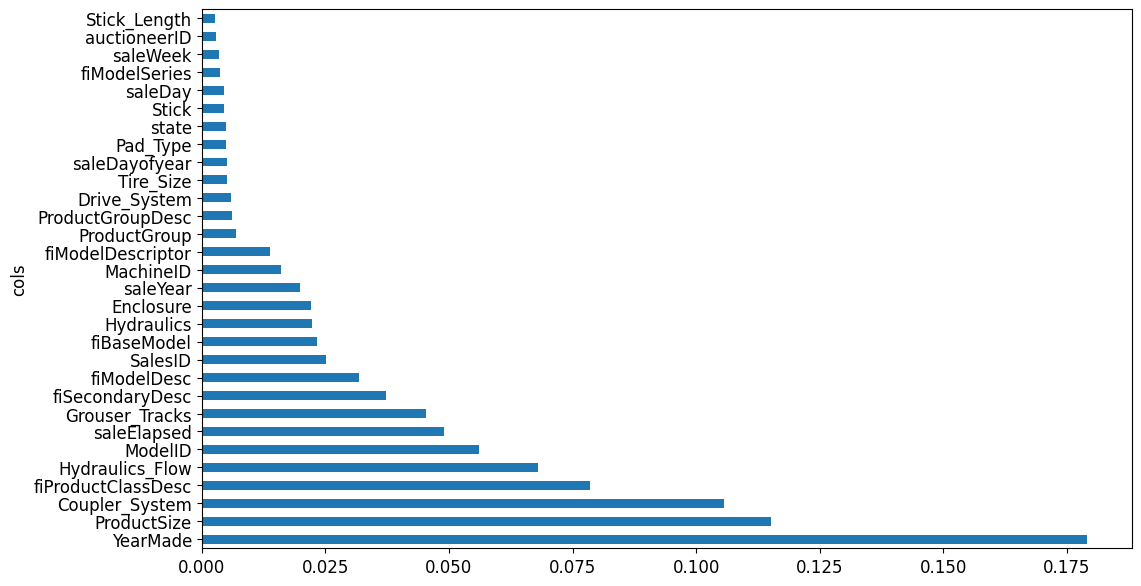

In [91]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

The way these importances are calculated is quite simple yet elegant. The feature importance algorithm loops through each tree, and then recursively explores each branch. At each branch, it looks to see what feature was used for that split, and how much the model improves as a result of that split. The improvement (weighted by the number of rows in that group) is added to the importance score for that feature. This is summed across all branches of all trees, and finally the scores are normalized such that they add to 1.

### Removing Low-Importance Variables

It seems likely that we could use just a subset of the columns by removing the variables of low importance and still get good results. Let's try just keeping those with a feature importance greater than 0.005:

In [92]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

22

We can retrain our model using just this subset of the columns:

In [93]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [94]:
m = rf(xs_imp, y)

And here's the result:

In [95]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.017794, 0.023091)

Our accuracy is about the same, but we have far fewer columns to study:

In [96]:
len(xs.columns), len(xs_imp.columns)

(66, 22)

We've found that generally the first step to improving a model is simplifying it—78 columns was too many for us to study them all in depth! Furthermore, in practice often a simpler, more interpretable model is easier to roll out and maintain.

This also makes our feature importance plot easier to interpret. Let's look at it again:

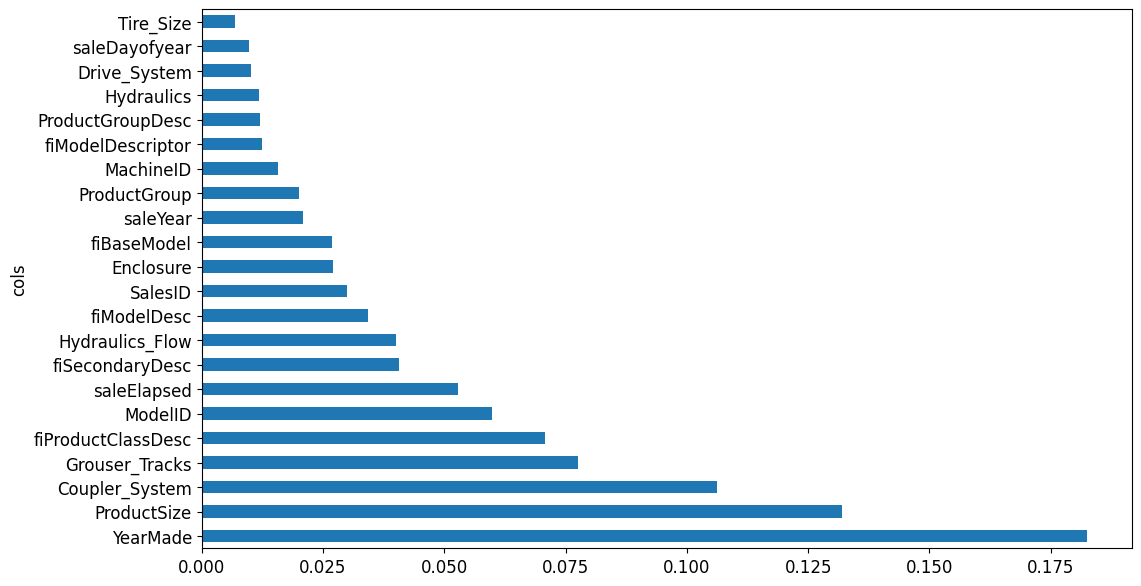

In [97]:
plot_fi(rf_feat_importance(m, xs_imp));

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings: for example, `ProductGroup` and `ProductGroupDesc`. Let's try to remove any redundent features. 

### Removing Redundant Features

Let's start with:

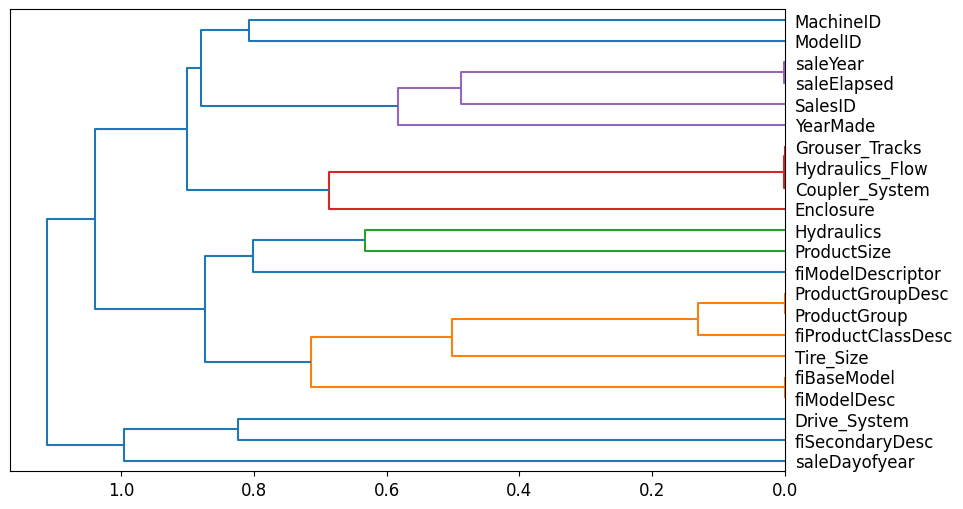

In [98]:
cluster_columns(xs_imp)

In this chart, the pairs of columns that are most similar are the ones that were merged together early, far from the "root" of the tree at the left. Unsurprisingly, the fields `ProductGroup` and `ProductGroupDesc` were merged quite early, as were `saleYear` and `saleElapsed` and `fiModelDesc` and `fiBaseModel`. These might be so closely correlated they are practically synonyms for each other.

> note: Determining Similarity: The most similar pairs are found by calculating the _rank correlation_, which means that all the values are replaced with their _rank_ (i.e., first, second, third, etc. within the column), and then the _correlation_ is calculated. (Feel free to skip over this minor detail though, since it's not going to come up again in the book!)

Let's try removing some of these closely related features to see if the model can be simplified without impacting the accuracy. First, we create a function that quickly trains a random forest and returns the OOB score, by using a lower `max_samples` and higher `min_samples_leaf`. The OOB score is a number returned by sklearn that ranges between 1.0 for a perfect model and 0.0 for a random model. (In statistics it's called *R^2*, although the details aren't important for this explanation.) We don't need it to be very accurate—we're just going to use it to compare different models, based on removing some of the possibly redundant columns:

In [99]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

Here's our baseline:

In [100]:
get_oob(xs_imp)

0.8752933023087708

Now we try removing each of our potentially redundant variables, one at a time:

In [101]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8743762603279477,
 'saleElapsed': 0.8709318245699893,
 'ProductGroupDesc': 0.875237772652143,
 'ProductGroup': 0.8747907287329773,
 'fiModelDesc': 0.8730628134160421,
 'fiBaseModel': 0.8736093081978313,
 'Hydraulics_Flow': 0.8749973071128565,
 'Grouser_Tracks': 0.8755886635096167,
 'Coupler_System': 0.8754612757351533}

Now let's try dropping multiple variables. We'll drop one from each of the tightly aligned pairs we noticed earlier. Let's see what that does:

In [102]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.874426734302368

Looking good! This is really not much worse than the model with all the fields. Let's create DataFrames without these columns, and save them:

In [103]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [104]:
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

We can load them back later with:

In [105]:
xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')

Now we can check our RMSE again, to confirm that the accuracy hasn't substantially changed.

In [106]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.017929, 0.02325)

By focusing on the most important variables, and removing some redundant ones, we've greatly simplified our model. Now, let's see how those variables affect our predictions using partial dependence plots.

### Partial Dependence

As we've seen, the two most important predictors are `ProductSize` and `YearMade`. We'd like to understand the relationship between these predictors and sale price. It's a good idea to first check the count of values per category (provided by the Pandas `value_counts` method), to see how common each category is:

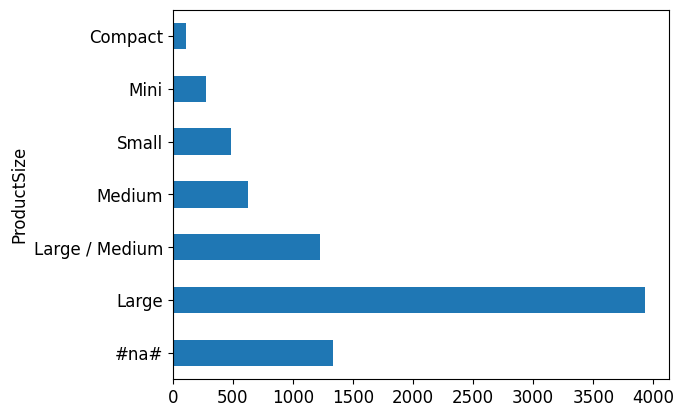

In [107]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

The largrest group is `#na#`, which is the label fastai applies to missing values.

Let's do the same thing for `YearMade`. Since this is a numeric feature, we'll need to draw a histogram, which groups the year values into a few discrete bins:

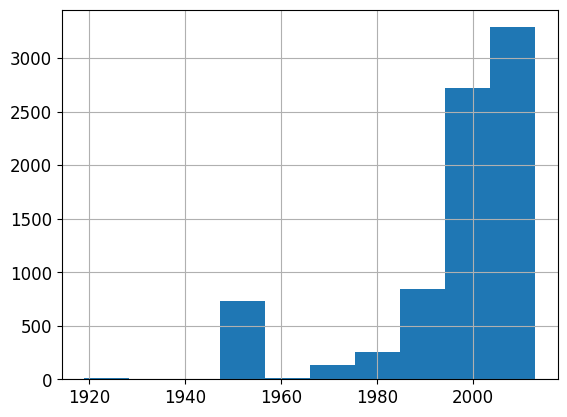

In [108]:
ax = valid_xs_final['YearMade'].hist()

Other than the special value 1950 which we used for coding missing year values, most of the data is from after 1990.

Now we're ready to look at *partial dependence plots*. Partial dependence plots try to answer the question: if a row varied on nothing other than the feature in question, how would it impact the dependent variable?

For instance, how does `YearMade` impact sale price, all other things being equal?

To answer this question, we can't just take the average sale price for each `YearMade`. The problem with that approach is that many other things vary from year to year as well, such as which products are sold, how many products have air-conditioning, inflation, and so forth. So, merely averaging over all the auctions that have the same `YearMade` would also capture the effect of how every other field also changed along with `YearMade` and how that overall change affected price.

Instead, what we do is replace every single value in the `YearMade` column with 1950, and then calculate the predicted sale price for every auction, and take the average over all auctions. Then we do the same for 1951, 1952, and so forth until our final year of 2011. This isolates the effect of only `YearMade` (even if it does so by averaging over some imagined records where we assign a `YearMade` value that might never actually exist alongside some other values). 

> A: If you are philosophically minded it is somewhat dizzying to contemplate the different kinds of hypotheticality that we are juggling to make this calculation. First, there's the fact that _every_ prediction is hypothetical, because we are not noting empirical data. Second, there's the point that we're _not_ merely interested in asking how sale price would change if we changed `YearMade` and everything else along with it. Rather, we're very specifically asking, how sale price would change in a hypothetical world where only `YearMade` changed. Phew! It is impressive that we can ask such questions. I recommend Judea Pearl and Dana Mackenzie's recent book on causality, _The Book of Why_ (Basic Books), if you're interested in more deeply exploring formalisms for analyzing these subtleties.

With these averages, we can then plot each of these years on the x-axis, and each of the predictions on the y-axis. This, finally, is a partial dependence plot. Let's take a look:

In [110]:
np.tanh(np.e)

0.9913289158005999

In [109]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);

ImportError: cannot import name 'plot_partial_dependence' from 'sklearn.inspection' (c:\Users\lenovo\miniconda3\envs\fastai\lib\site-packages\sklearn\inspection\__init__.py)

Looking first of all at the `YearMade` plot, and specifically at the section covering the years after 1990 (since as we noted this is where we have the most data), we can see a nearly linear relationship between year and price. Remember that our dependent variable is after taking the logarithm, so this means that in practice there is an exponential increase in price. This is what we would expect: depreciation is generally recognized as being a multiplicative factor over time, so, for a given sale date, varying year made ought to show an exponential relationship with sale price.

The `ProductSize` partial plot is a bit concerning. It shows that the final group, which we saw is for missing values, has the lowest price. To use this insight in practice, we would want to find out *why* it's missing so often, and what that *means*. Missing values can sometimes be useful predictors—it entirely depends on what causes them to be missing. Sometimes, however, they can indicate *data leakage*.

### Data Leakage

In  the paper ["Leakage in Data Mining: Formulation, Detection, and Avoidance"](https://dl.acm.org/doi/10.1145/2020408.2020496), Shachar Kaufman, Saharon Rosset, and Claudia Perlich describe leakage as: 

> : The introduction of information about the target of a data mining problem, which should not be legitimately available to mine from. A trivial example of leakage would be a model that uses the target itself as an input, thus concluding for example that 'it rains on rainy days'. In practice, the introduction of this illegitimate information is unintentional, and facilitated by the data collection, aggregation and preparation process.

They give as an example:

> : A real-life business intelligence project at IBM where potential customers for certain products were identified, among other things, based on keywords found on their websites. This turned out to be leakage since the website content used for training had been sampled at the point in time where the potential customer has already become a customer, and where the website contained traces of the IBM products purchased, such as the word 'Websphere' (e.g., in a press release about the purchase or a specific product feature the client uses).

Data leakage is subtle and can take many forms. In particular, missing values often represent data leakage.

For instance, Jeremy competed in a Kaggle competition designed to predict which researchers would end up receiving research grants. The information was provided by a university and included thousands of examples of research projects, along with information about the researchers involved and data on whether or not each grant was eventually accepted. The university hoped to be able to use the models developed in this competition to rank which grant applications were most likely to succeed, so it could prioritize its processing.

Jeremy used a random forest to model the data, and then used feature importance to find out which features were most predictive. He noticed three surprising things:

- The model was able to correctly predict who would receive grants over 95% of the time.
- Apparently meaningless identifier columns were the most important predictors.
- The day of week and day of year columns were also highly predictive; for instance, the vast majority of grant applications dated on a Sunday were accepted, and many accepted grant applications were dated on January 1.

For the identifier columns, one partial dependence plot per column showed that when the information was missing the application was almost always rejected. It turned out that in practice, the university only filled out much of this information *after* a grant application was accepted. Often, for applications that were not accepted, it was just left blank. Therefore, this information was not something that was actually available at the time that the application was received, and it would not be available for a predictive model—it was data leakage.

In the same way, the final processing of successful applications was often done automatically as a batch at the end of the week, or the end of the year. It was this final processing date which ended up in the data, so again, this information, while predictive, was not actually available at the time that the application was received.

This example showcases the most practical and simple approaches to identifying data leakage, which are to build a model and then:

- Check whether the accuracy of the model is *too good to be true*.
- Look for important predictors that don't make sense in practice.
- Look for partial dependence plot results that don't make sense in practice.

Thinking back to our bear detector, this mirrors the advice that we provided in <<chapter_production>>—it is often a good idea to build a model first and then do your data cleaning, rather than vice versa. The model can help you identify potentially problematic data issues.

It can also help you identify which factors influence specific predictions, with tree interpreters.

### Tree Interpreter

In [ ]:
#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

At the start of this section, we said that we wanted to be able to answer five questions:

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?

We've handled four of these already; only the second question remains. To answer this question, we need to use the `treeinterpreter` library. We'll also use the `waterfallcharts` library to draw the chart of the results.

    !pip install treeinterpreter
    !pip install waterfallcharts

We have already seen how to compute feature importances across the entire random forest. The basic idea was to look at the contribution of each variable to improving the model, at each branch of every tree, and then add up all of these contributions per variable.

We can do exactly the same thing, but for just a single row of data. For instance, let's say we are looking at some particular item at auction. Our model might predict that this item will be very expensive, and we want to know why. So, we take that one row of data and put it through the first decision tree, looking to see what split is used at each point throughout the tree. For each split, we see what the increase or decrease in the addition is, compared to the parent node of the tree. We do this for every tree, and add up the total change in importance by split variable.

For instance, let's pick the first few rows of our validation set:

In [ ]:
row = valid_xs_final.iloc[:5]

We can then pass these to `treeinterpreter`:

In [ ]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

`prediction` is simply the prediction that the random forest makes. `bias` is the prediction based on taking the mean of the dependent variable (i.e., the *model* that is the root of every tree). `contributions` is the most interesting bit—it tells us the total change in predicition due to each of the independent variables. Therefore, the sum of `contributions` plus `bias` must equal the `prediction`, for each row. Let's look just at the first row:

In [ ]:
prediction[0], bias[0], contributions[0].sum()

The clearest way to display the contributions is with a *waterfall plot*. This shows how the positive and negative contributions from all the independent variables sum up to create the final prediction, which is the righthand column labeled "net" here:

In [ ]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

This kind of information is most useful in production, rather than during model development. You can use it to provide useful information to users of your data product about the underlying reasoning behind the predictions.

Now that we covered some classic machine learning techniques to solve this problem, let's see how deep learning can help!

## Extrapolation and Neural Networks

A problem with random forests, like all machine learning or deep learning algorithms, is that they don't always generalize well to new data. We will see in which situations neural networks generalize better, but first, let's look at the extrapolation problem that random forests have.

### The Extrapolation Problem

In [ ]:
#hide
np.random.seed(42)

Let's consider the simple task of making predictions from 40 data points showing a slightly noisy linear relationship:

In [ ]:
x_lin = torch.linspace(0,20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);

Although we only have a single independent variable, sklearn expects a matrix of independent variables, not a single vector. So we have to turn our vector into a matrix with one column. In other words, we have to change the *shape* from `[40]` to `[40,1]`. One way to do that is with the `unsqueeze` method, which adds a new unit axis to a tensor at the requested dimension:

In [ ]:
xs_lin = x_lin.unsqueeze(1)
x_lin.shape,xs_lin.shape

A more flexible approach is to slice an array or tensor with the special value `None`, which introduces an additional unit axis at that location:

In [ ]:
x_lin[:,None].shape

We can now create a random forest for this data. We'll use only the first 30 rows to train the model:

In [ ]:
m_lin = RandomForestRegressor().fit(xs_lin[:30],y_lin[:30])

Then we'll test the model on the full dataset. The blue dots are the training data, and the red dots are the predictions:

In [ ]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

We have a big problem! Our predictions outside of the domain that our training data covered are all too low. Why do you suppose this is?

Remember, a random forest just averages the predictions of a number of trees. And a tree simply predicts the average value of the rows in a leaf. Therefore, a tree and a random forest can never predict values outside of the range of the training data. This is particularly problematic for data where there is a trend over time, such as inflation, and you wish to make predictions for a future time. Your predictions will be systematically too low.

But the problem extends beyond time variables. Random forests are not able to extrapolate outside of the types of data they have seen, in a more general sense. That's why we need to make sure our validation set does not contain out-of-domain data.

### Finding Out-of-Domain Data

Sometimes it is hard to know whether your test set is distributed in the same way as your training data, or, if it is different, what columns reflect that difference. There's actually an easy way to figure this out, which is to use a random forest!

But in this case we don't use the random forest to predict our actual dependent variable. Instead, we try to predict whether a row is in the validation set or the training set. To see this in action, let's combine our training and validation sets together, create a dependent variable that represents which dataset each row comes from, build a random forest using that data, and get its feature importance:

In [ ]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

This shows that there are three columns that differ significantly between the training and validation sets: `saleElapsed`, `SalesID`, and `MachineID`. It's fairly obvious why this is the case for `saleElapsed`: it's the number of days between the start of the dataset and each row, so it directly encodes the date. The difference in `SalesID` suggests that identifiers for auction sales might increment over time. `MachineID` suggests something similar might be happening for individual items sold in those auctions.

Let's get a baseline of the original random forest model's RMSE, then see what the effect is of removing each of these columns in turn:

In [ ]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

It looks like we should be able to remove `SalesID` and `MachineID` without losing any accuracy. Let's check:

In [ ]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

Removing these variables has slightly improved the model's accuracy; but more importantly, it should make it more resilient over time, and easier to maintain and understand. We recommend that for all datasets you try building a model where your dependent variable is `is_valid`, like we did here. It can often uncover subtle *domain shift* issues that you may otherwise miss.

One thing that might help in our case is to simply avoid using old data. Often, old data shows relationships that just aren't valid any more. Let's try just using the most recent few years of the data:

In [ ]:
xs['saleYear'].hist();

Here's the result of training on this subset:

In [ ]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [ ]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

It's a tiny bit better, which shows that you shouldn't always just use your entire dataset; sometimes a subset can be better.

Let's see if using a neural network helps.

### Using a Neural Network

We can use the same approach to build a neural network model. Let's first replicate the steps we took to set up the `TabularPandas` object:

In [ ]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

We can leverage the work we did to trim unwanted columns in the random forest by using the same set of columns for our neural network:

In [ ]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

Categorical columns are handled very differently in neural networks, compared to decision tree approaches. As we saw in <<chapter_collab>>, in a neural net a great way to handle categorical variables is by using embeddings. To create embeddings, fastai needs to determine which columns should be treated as categorical variables. It does this by comparing the number of distinct levels in the variable to the value of the `max_card` parameter. If it's lower, fastai will treat the variable as categorical. Embedding sizes larger than 10,000 should generally only be used after you've tested whether there are better ways to group the variable, so we'll use 9,000 as our `max_card`:

In [ ]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In this case, there's one variable that we absolutely do not want to treat as categorical: the `saleElapsed` variable. A categorical variable cannot, by definition, extrapolate outside the range of values that it has seen, but we want to be able to predict auction sale prices in the future. Let's verify that `cont_cat_split` did the correct thing.

In [ ]:
cont_nn

Let's take a look at the cardinality of each of the categorical variables that we have chosen so far:

In [ ]:
df_nn_final[cat_nn].nunique()

The fact that there are two variables pertaining to the "model" of the equipment, both with similar very high cardinalities, suggests that they may contain similar, redundant information. Note that we would not necessarily see this when analyzing redundant features, since that relies on similar variables being sorted in the same order (that is, they need to have similarly named levels). Having a column with 5,000 levels means needing 5,000 columns in our embedding matrix, which would be nice to avoid if possible. Let's see what the impact of removing one of these model columns has on the random forest:

In [ ]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

There's minimal impact, so we will remove it as a predictor for our neural network:

In [ ]:
cat_nn.remove('fiModelDescriptor')

We can create our `TabularPandas` object in the same way as when we created our random forest, with one very important addition: normalization. A random forest does not need any normalization—the tree building procedure cares only about the order of values in a variable, not at all about how they are scaled. But as we have seen, a neural network definitely does care about this. Therefore, we add the `Normalize` processor when we build our `TabularPandas` object:

In [ ]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

Tabular models and data don't generally require much GPU RAM, so we can use larger batch sizes:

In [ ]:
dls = to_nn.dataloaders(1024)

As we've discussed, it's a good idea to set `y_range` for regression models, so let's find the min and max of our dependent variable:

In [ ]:
y = to_nn.train.y
y.min(),y.max()

We can now create the `Learner` to create this tabular model. As usual, we use the application-specific learner function, to take advantage of its application-customized defaults. We set the loss function to MSE, since that's what this competition uses.

By default, for tabular data fastai creates a neural network with two hidden layers, with 200 and 100 activations, respectively. This works quite well for small datasets, but here we've got quite a large dataset, so we increase the layer sizes to 500 and 250:

In [ ]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

In [ ]:
learn.lr_find()

There's no need to use `fine_tune`, so we'll train with `fit_one_cycle` for a few epochs and see how it looks:

In [ ]:
learn.fit_one_cycle(5, 1e-2)

We can use our `r_mse` function to compare the result to the random forest result we got earlier:

In [ ]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

It's quite a bit better than the random forest (although it took longer to train, and it's fussier about hyperparameter tuning).

Before we move on, let's save our model in case we want to come back to it again later:

In [ ]:
learn.save('nn')

### Sidebar: fastai's Tabular Classes

In fastai, a tabular model is simply a model that takes columns of continuous or categorical data, and predicts a category (a classification model) or a continuous value (a regression model). Categorical independent variables are passed through an embedding, and concatenated, as we saw in the neural net we used for collaborative filtering, and then continuous variables are concatenated as well.

The model created in `tabular_learner` is an object of class `TabularModel`. Take a look at the source for `tabular_learner` now (remember, that's `tabular_learner??` in Jupyter). You'll see that like `collab_learner`, it first calls `get_emb_sz` to calculate appropriate embedding sizes (you can override these by using the `emb_szs` parameter, which is a dictionary containing any column names you want to set sizes for manually), and it sets a few other defaults. Other than that, it just creates the `TabularModel`, and passes that to `TabularLearner` (note that `TabularLearner` is identical to `Learner`, except for a customized `predict` method).

That means that really all the work is happening in `TabularModel`, so take a look at the source for that now. With the exception of the `BatchNorm1d` and `Dropout` layers (which we'll be learning about shortly), you now have the knowledge required to understand this whole class. Take a look at the discussion of `EmbeddingNN` at the end of the last chapter. Recall that it passed `n_cont=0` to `TabularModel`. We now can see why that was: because there are zero continuous variables (in fastai the `n_` prefix means "number of," and `cont` is an abbreviation for "continuous").

### End sidebar

Another thing that can help with generalization is to use several models and average their predictions—a technique, as mentioned earlier, known as *ensembling*.

## Ensembling

Think back to the original reasoning behind why random forests work so well: each tree has errors, but those errors are not correlated with each other, so the average of those errors should tend towards zero once there are enough trees. Similar reasoning could be used to consider averaging the predictions of models trained using different algorithms.

In our case, we have two very different models, trained using very different algorithms: a random forest, and a neural network. It would be reasonable to expect that the kinds of errors that each one makes would be quite different. Therefore, we might expect that the average of their predictions would be better than either one's individual predictions.

As we saw earlier, a random forest is itself an ensemble. But we can then include a random forest in *another* ensemble—an ensemble of the random forest and the neural network! While ensembling won't make the difference between a successful and an unsuccessful modeling process, it can certainly add a nice little boost to any models that you have built.

One minor issue we have to be aware of is that our PyTorch model and our sklearn model create data of different types: PyTorch gives us a rank-2 tensor (i.e, a column matrix), whereas NumPy gives us a rank-1 array (a vector). `squeeze` removes any unit axes from a tensor, and `to_np` converts it into a NumPy array:

In [ ]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

This gives us a better result than either model achieved on its own:

In [ ]:
r_mse(ens_preds,valid_y)

In fact, this result is better than any score shown on the Kaggle leaderboard. It's not directly comparable, however, because the Kaggle leaderboard uses a separate dataset that we do not have access to. Kaggle does not allow us to submit to this old competition to find out how we would have done, but our results certainly look very encouraging!

### Boosting

So far our approach to ensembling has been to use *bagging*, which involves combining many models (each trained on a different data subset) together by averaging them. As we saw, when this is applied to decision trees, this is called a *random forest*.

There is another important approach to ensembling, called *boosting*, where we add models instead of averaging them. Here is how boosting works:

- Train a small model that underfits your dataset.
- Calculate the predictions in the training set for this model.
- Subtract the predictions from the targets; these are called the "residuals" and represent the error for each point in the training set.
- Go back to step 1, but instead of using the original targets, use the residuals as the targets for the training.
- Continue doing this until you reach some stopping criterion, such as a maximum number of trees, or you observe your validation set error getting worse.

Using this approach, each new tree will be attempting to fit the error of all of the previous trees combined. Because we are continually creating new residuals, by subtracting the predictions of each new tree from the residuals from the previous tree, the residuals will get smaller and smaller.

To make predictions with an ensemble of boosted trees, we calculate the predictions from each tree, and then add them all together. There are many models following this basic approach, and many names for the same models. *Gradient boosting machines* (GBMs) and *gradient boosted decision trees* (GBDTs) are the terms you're most likely to come across, or you may see the names of specific libraries implementing these; at the time of writing, *XGBoost* is the most popular.

Note that, unlike with random forests, with this approach there is nothing to stop us from overfitting. Using more trees in a random forest does not lead to overfitting, because each tree is independent of the others. But in a boosted ensemble, the more trees you have, the better the training error becomes, and eventually you will see overfitting on the validation set.

We are not going to go into detail on how to train a gradient boosted tree ensemble here, because the field is moving rapidly, and any guidance we give will almost certainly be outdated by the time you read this. As we write this, sklearn has just added a `HistGradientBoostingRegressor` class that provides excellent performance. There are many hyperparameters to tweak for this class, and for all gradient boosted tree methods we have seen. Unlike random forests, gradient boosted trees are extremely sensitive to the choices of these hyperparameters; in practice, most people use a loop that tries a range of different hyperparameters to find the ones that work best.

One more technique that has gotten great results is to use embeddings learned by a neural net in a machine learning model.

### Combining Embeddings with Other Methods

The abstract of the entity embedding paper we mentioned at the start of this chapter states: "the embeddings obtained from the trained neural network boost the performance of all tested machine learning methods considerably when used as the input features instead". It includes the very interesting table in <<embedding_mixed>>.

<img alt="Embeddings combined with other methods" width="500" id="embedding_mixed" caption="Effects of using neural network embeddings as input to other machine learning methods (courtesy of Cheng Guo and Felix Berkhahn)" src="images/att_00054.png">

This is showing the mean average percent error (MAPE) compared among four different modeling techniques, three of which we have already seen, along with *k*-nearest neighbors (KNN), which is a very simple baseline method. The first numeric column contains the results of using the methods on the data provided in the competition; the second column shows what happens if you first train a neural network with categorical embeddings, and then use those categorical embeddings instead of the raw categorical columns in the model. As you see, in every case, the models are dramatically improved by using the embeddings instead of the raw categories.

This is a really important result, because it shows that you can get much of the performance improvement of a neural network without actually having to use a neural network at inference time. You could just use an embedding, which is literally just an array lookup, along with a small decision tree ensemble.

These embeddings need not even be necessarily learned separately for each model or task in an organization. Instead, once a set of embeddings are learned for some column for some task, they could be stored in a central place, and reused across multiple models. In fact, we know from private communication with other practitioners at large companies that this is already happening in many places.

## Conclusion: Our Advice for Tabular Modeling

We have dicussed two approaches to tabular modeling: decision tree ensembles and neural networks. We've also mentioned two different decision tree ensembles: random forests, and gradient boosting machines. Each is very effective, but each also has compromises:

- *Random forests* are the easiest to train, because they are extremely resilient to hyperparameter choices and require very little preprocessing. They are very fast to train, and should not overfit if you have enough trees. But they can be a little less accurate, especially if extrapolation is required, such as predicting future time periods.

- *Gradient boosting machines* in theory are just as fast to train as random forests, but in practice you will have to try lots of different hyperparameters. They can overfit, but they are often a little more accurate than random forests.

- *Neural networks* take the longest time to train, and require extra preprocessing, such as normalization; this normalization needs to be used at inference time as well. They can provide great results and extrapolate well, but only if you are careful with your hyperparameters and take care to avoid overfitting.

We suggest starting your analysis with a random forest. This will give you a strong baseline, and you can be confident that it's a reasonable starting point. You can then use that model for feature selection and partial dependence analysis, to get a better understanding of your data.

From that foundation, you can try neural nets and GBMs, and if they give you significantly better results on your validation set in a reasonable amount of time, you can use them. If decision tree ensembles are working well for you, try adding the embeddings for the categorical variables to the data, and see if that helps your decision trees learn better.

## Questionnaire

1. What is a continuous variable?
1. What is a categorical variable?
1. Provide two of the words that are used for the possible values of a categorical variable.
1. What is a "dense layer"?
1. How do entity embeddings reduce memory usage and speed up neural networks?
1. What kinds of datasets are entity embeddings especially useful for?
1. What are the two main families of machine learning algorithms?
1. Why do some categorical columns need a special ordering in their classes? How do you do this in Pandas?
1. Summarize what a decision tree algorithm does.
1. Why is a date different from a regular categorical or continuous variable, and how can you preprocess it to allow it to be used in a model?
1. Should you pick a random validation set in the bulldozer competition? If no, what kind of validation set should you pick?
1. What is pickle and what is it useful for?
1. How are `mse`, `samples`, and `values` calculated in the decision tree drawn in this chapter?
1. How do we deal with outliers, before building a decision tree?
1. How do we handle categorical variables in a decision tree?
1. What is bagging?
1. What is the difference between `max_samples` and `max_features` when creating a random forest?
1. If you increase `n_estimators` to a very high value, can that lead to overfitting? Why or why not?
1. In the section "Creating a Random Forest", just after <<max_features>>, why did `preds.mean(0)` give the same result as our random forest?
1. What is "out-of-bag-error"?
1. Make a list of reasons why a model's validation set error might be worse than the OOB error. How could you test your hypotheses?
1. Explain why random forests are well suited to answering each of the following question:
   - How confident are we in our predictions using a particular row of data?
   - For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
   - Which columns are the strongest predictors?
   - How do predictions vary as we vary these columns?
1. What's the purpose of removing unimportant variables?
1. What's a good type of plot for showing tree interpreter results?
1. What is the "extrapolation problem"?
1. How can you tell if your test or validation set is distributed in a different way than your training set?
1. Why do we ensure `saleElapsed` is a continuous variable, even although it has less than 9,000 distinct values?
1. What is "boosting"?
1. How could we use embeddings with a random forest? Would we expect this to help?
1. Why might we not always use a neural net for tabular modeling?

### Further Research

1. Pick a competition on Kaggle with tabular data (current or past) and try to adapt the techniques seen in this chapter to get the best possible results. Compare your results to the private leaderboard.
1. Implement the decision tree algorithm in this chapter from scratch yourself, and try it on the dataset you used in the first exercise.
1. Use the embeddings from the neural net in this chapter in a random forest, and see if you can improve on the random forest results we saw.
1. Explain what each line of the source of `TabularModel` does (with the exception of the `BatchNorm1d` and `Dropout` layers).